# Time Series Experiment Results Visualization

This notebook provides comprehensive visualizations for time series forecasting experiments.

In [5]:
# Cell 1: Imports and Configuration
import os
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Optional, Tuple
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.figsize'] = (12, 8)

# Base path
RESULTS_DIR = Path('results')

In [6]:
# Cell 2: Global Configuration - Customize these settings

# Color configuration for models (consistent across all plots)
MODEL_COLORS = {
    'BrickTS': '#1f77b4', 'DUET': '#ff7f0e', 'iTransformer': '#2ca02c',
    'PatchTST': '#d62728', 'DLinear': '#9467bd', 'TimesNet': '#8c564b',
    'Autoformer': '#e377c2', 'FEDformer': '#7f7f7f', 'Informer': '#bcbd22',
    'Transformer': '#17becf', 'Linear': '#aec7e8', 'TSMixer': '#ffbb78',
    'TimeMixer': '#98df8a', 'SegRNN': '#ff9896', 'TCN': '#c5b0d5',
    'RNN': '#c49c94', 'SCINet': '#f7b6d2', 'MICN': '#c7c7c7',
    'TiDE': '#dbdb8d', 'LightTS': '#9edae5', 'Pyraformer': '#d6616b',
}

# Mode colors and styles
MODE_COLORS = {'CD': '#0571b0', 'CI': '#ca0020'}
MODE_LINESTYLES = {'CD': '-', 'CI': '--'}
MODE_MARKERS = {'CD': 'o', 'CI': 's'}

# Model display name mapping
MODEL_RENAME = {
    'linear': 'Linear', 'dlinear': 'DLinear', 'tcn': 'TCN',
    'transformer': 'Transformer', 'rnn': 'RNN', 'timemixer': 'TimeMixer',
    'tsmixer': 'TSMixer', 'autoformer': 'Autoformer', 'segrnn': 'SegRNN',
    'timesnet': 'TimesNet', 'scinet': 'SCINet', 'tide': 'TiDE',
    'lightts': 'LightTS', 'pyraformer': 'Pyraformer', 'informer': 'Informer',
    'itransformer': 'iTransformer', 'patchtst': 'PatchTST',
    'fedformer': 'FEDformer', 'brickts': 'BrickTS', 'duet': 'DUET', 'micn': 'MICN',
}

def get_model_color(model_name: str) -> str:
    """Get consistent color for a model."""
    name = MODEL_RENAME.get(model_name.lower(), model_name)
    return MODEL_COLORS.get(name, '#333333')

def rename_model(model_name: str) -> str:
    """Get display name for a model."""
    return MODEL_RENAME.get(model_name.lower(), model_name)

def get_default_pred_len(dataset: str) -> int:
    """Get default pred_len based on dataset type."""
    ds_lower = dataset.lower()
    if 'milano' in ds_lower or 'ili' in ds_lower or 'illness' in ds_lower:
        return 36
    return 96

In [7]:
# Cell 3: Data Loading Functions

def load_json_results(results_dir: Path = RESULTS_DIR) -> pd.DataFrame:
    """
    Load all *_results.json files and create a unified DataFrame.
    
    Returns:
        DataFrame with columns: dataset, seq_len, pred_len, model, mode, channel,
                               mae, mse, rmse, mape, mspe, mae_std, mse_std, rmse_std,
                               train_time_mean, train_memory_gb_mean, inference_time_mean,
                               inference_memory_gb_mean, num_params
    """
    records = []
    json_pattern = str(results_dir / '**' / '*_results.json')
    json_files = glob.glob(json_pattern, recursive=True)
    
    for json_path in json_files:
        path = Path(json_path)
        parts = path.parts
        results_idx = next(i for i, p in enumerate(parts) if p == 'results')
        
        dataset = parts[results_idx + 1]
        len_part = parts[results_idx + 2]
        seq_len, pred_len = map(int, len_part.split('_'))
        
        filename = path.stem.replace('_results', '')
        parts_name = filename.rsplit('_', 1)
        model = parts_name[0]
        mode = parts_name[1]
        
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        # Handle CD format (has 'overall' key)
        if 'overall' in data:
            overall = data['overall']
            scalability = data.get('scalability', {})
            std_data = overall.get('std', {})
            
            record = {
                'dataset': dataset, 'seq_len': seq_len, 'pred_len': pred_len,
                'model': model, 'mode': mode, 'channel': 'overall',
                'mae': overall.get('mae'), 'mse': overall.get('mse'),
                'rmse': overall.get('rmse'), 'mape': overall.get('mape'),
                'mspe': overall.get('mspe'),
                'mae_std': std_data.get('mae'), 'mse_std': std_data.get('mse'),
                'rmse_std': std_data.get('rmse'),
                'train_time_mean': scalability.get('train_time_mean'),
                'train_time_std': scalability.get('train_time_std'),
                'train_memory_gb_mean': scalability.get('train_memory_gb_mean'),
                'inference_time_mean': scalability.get('inference_time_mean'),
                'inference_time_std': scalability.get('inference_time_std'),
                'inference_memory_gb_mean': scalability.get('inference_memory_gb_mean'),
                'num_params': scalability.get('num_params'),
            }
            records.append(record)
            
            # Also add per-channel data
            for channel, ch_data in data.get('per_channel', {}).items():
                ch_std = ch_data.get('std', {})
                ch_record = {
                    'dataset': dataset, 'seq_len': seq_len, 'pred_len': pred_len,
                    'model': model, 'mode': mode, 'channel': channel,
                    'mae': ch_data.get('mae'), 'mse': ch_data.get('mse'),
                    'rmse': ch_data.get('rmse'), 'mape': ch_data.get('mape'),
                    'mspe': ch_data.get('mspe'),
                    'mae_std': ch_std.get('mae'), 'mse_std': ch_std.get('mse'),
                    'rmse_std': ch_std.get('rmse'),
                    'train_time_mean': scalability.get('train_time_mean'),
                    'train_time_std': scalability.get('train_time_std'),
                    'train_memory_gb_mean': scalability.get('train_memory_gb_mean'),
                    'inference_time_mean': scalability.get('inference_time_mean'),
                    'inference_time_std': scalability.get('inference_time_std'),
                    'inference_memory_gb_mean': scalability.get('inference_memory_gb_mean'),
                    'num_params': scalability.get('num_params'),
                }
                records.append(ch_record)
        
        # Handle CI format (channel as top-level key)
        else:
            for channel, ch_data in data.items():
                scalability = ch_data.get('scalability', {})
                std_data = ch_data.get('std', {})
                
                record = {
                    'dataset': dataset, 'seq_len': seq_len, 'pred_len': pred_len,
                    'model': model, 'mode': mode, 'channel': channel,
                    'mae': ch_data.get('mae'), 'mse': ch_data.get('mse'),
                    'rmse': ch_data.get('rmse'), 'mape': ch_data.get('mape'),
                    'mspe': ch_data.get('mspe'),
                    'mae_std': std_data.get('mae'), 'mse_std': std_data.get('mse'),
                    'rmse_std': std_data.get('rmse'),
                    'train_time_mean': scalability.get('train_time_mean'),
                    'train_time_std': scalability.get('train_time_std'),
                    'train_memory_gb_mean': scalability.get('train_memory_gb_mean'),
                    'inference_time_mean': scalability.get('inference_time_mean'),
                    'inference_time_std': scalability.get('inference_time_std'),
                    'inference_memory_gb_mean': scalability.get('inference_memory_gb_mean'),
                    'num_params': scalability.get('num_params'),
                }
                records.append(record)
    
    return pd.DataFrame(records)


def load_npy_predictions(results_dir: Path, dataset: str, seq_len: int, pred_len: int,
                         model: str, mode: str, repeat: int = 0, channel: str = 'OT') -> Dict:
    """Load prediction numpy files for a specific experiment."""
    if mode == 'CD':
        folder_name = f"{model}_{mode}_repeat{repeat}"
    else:
        folder_name = f"{model}_{mode}_{channel}_repeat{repeat}"
    
    base_path = results_dir / dataset / f"{seq_len}_{pred_len}" / model / folder_name
    
    result = {}
    for fname in ['input', 'pred', 'true', 'metrics', 'per_channel_metrics', 'scalability']:
        fpath = base_path / f"{fname}.npy"
        if fpath.exists():
            result[fname] = np.load(fpath, allow_pickle=True)
    
    return result

In [8]:
# Cell 4: Load Data

df_results = load_json_results(RESULTS_DIR)

print(f"Loaded {len(df_results)} records")
print(f"Datasets: {df_results['dataset'].unique().tolist()}")
print(f"Models: {df_results['model'].unique().tolist()}")
print(f"Modes: {df_results['mode'].unique().tolist()}")
print(f"Pred lengths: {sorted(df_results['pred_len'].unique().tolist())}")

df_results.head(10)

Loaded 14 records
Datasets: ['milano_6165']
Models: ['BrickTS', 'DUET']
Modes: ['CD', 'CI']
Pred lengths: [36]


,dataset,seq_len,pred_len,model,mode,channel,mae,mse,rmse,mape,...,mae_std,mse_std,rmse_std,train_time_mean,train_time_std,train_memory_gb_mean,inference_time_mean,inference_time_std,inference_memory_gb_mean,num_params
0,milano_6165,36,36,BrickTS,CD,overall,0.317601,0.200674,0.447939,1.714198,...,0.003873,0.004487,0.005012,5.173601,1.000311,0.176006,0.020836,0.006258,0.022195,228852
1,milano_6165,36,36,BrickTS,CD,smsin,0.317863,0.196920,0.443736,1.327754,...,0.003155,0.003762,0.004252,5.173601,1.000311,0.176006,0.020836,0.006258,0.022195,228852
2,milano_6165,36,36,BrickTS,CD,smsout,0.360779,0.267207,0.516879,1.768328,...,0.003935,0.006730,0.006524,5.173601,1.000311,0.176006,0.020836,0.006258,0.022195,228852
3,milano_6165,36,36,BrickTS,CD,callin,0.304800,0.184174,0.429107,2.177020,...,0.005083,0.005464,0.006373,5.173601,1.000311,0.176006,0.020836,0.006258,0.022195,228852
4,milano_6165,36,36,BrickTS,CD,callout,0.316408,0.200894,0.448166,0.825081,...,0.004342,0.005753,0.006434,5.173601,1.000311,0.176006,0.020836,0.006258,0.022195,228852
5,milano_6165,36,36,BrickTS,CD,OT,0.288152,0.154176,0.392518,2.472807,...,0.007360,0.007997,0.010297,5.173601,1.000311,0.176006,0.020836,0.006258,0.022195,228852
6,milano_6165,36,36,BrickTS,CI,OT,0.263582,0.142572,0.377527,1.998466,...,0.004397,0.005014,0.006681,13.377964,5.736058,0.053024,0.026707,0.009364,0.033765,86244
7,milano_6165,36,36,DUET,CI,OT,0.361217,0.240479,0.488946,1.580070,...,0.025854,0.037267,0.037563,9.177254,2.106103,0.018301,0.025242,0.004463,0.017697,87016
8,milano_6165,36,36,DUET,CD,overall,0.428353,0.416340,0.645165,1.545193,...,0.008665,0.013086,0.010114,19.415805,5.562009,0.032236,0.071937,0.015875,0.018935,87024
9,milano_6165,36,36,DUET,CD,smsin,0.447503,0.457003,0.675961,1.691688,...,0.007662,0.012094,0.008919,19.415805,5.562009,0.032236,0.071937,0.015875,0.018935,87024


---
## Section 2: Unified Results Table

In [9]:
# Cell 5: Create Unified Results Table Function

def create_results_table(
    df: pd.DataFrame,
    metric: str = 'mse',
    channel: str = 'OT',
    dataset_order: Optional[List[str]] = None,
    model_order: Optional[List[str]] = None,
    pred_lens: Optional[List[int]] = None,
    show_std: bool = True,
) -> pd.DataFrame:
    """
    Create a unified results table with multi-index columns and rows.
    Columns: Dataset (multi-level with pred_len)
    Rows: Model (multi-level with mode CD/CI)
    """
    df_filtered = df[df['channel'] == channel].copy()
    
    if pred_lens is not None:
        df_filtered = df_filtered[df_filtered['pred_len'].isin(pred_lens)]
    
    datasets = dataset_order if dataset_order else sorted(df_filtered['dataset'].unique())
    models = model_order if model_order else sorted(df_filtered['model'].unique())
    modes = ['CD', 'CI']
    all_pred_lens = pred_lens if pred_lens else sorted(df_filtered['pred_len'].unique())
    
    col_tuples = []
    for ds in datasets:
        ds_pred_lens = df_filtered[df_filtered['dataset'] == ds]['pred_len'].unique()
        for pl in sorted(ds_pred_lens):
            if pl in all_pred_lens:
                col_tuples.append((ds, pl))
    
    col_index = pd.MultiIndex.from_tuples(col_tuples, names=['Dataset', 'Pred_Len'])
    row_tuples = [(m, mode) for m in models for mode in modes]
    row_index = pd.MultiIndex.from_tuples(row_tuples, names=['Model', 'Mode'])
    
    result_df = pd.DataFrame(index=row_index, columns=col_index, dtype=object)
    std_col = f"{metric}_std"
    
    for model in models:
        for mode in modes:
            for ds, pl in col_tuples:
                mask = (
                    (df_filtered['model'] == model) &
                    (df_filtered['mode'] == mode) &
                    (df_filtered['dataset'] == ds) &
                    (df_filtered['pred_len'] == pl)
                )
                subset = df_filtered[mask]
                
                if len(subset) > 0:
                    val = subset[metric].values[0]
                    if show_std and std_col in subset.columns and pd.notna(subset[std_col].values[0]):
                        std_val = subset[std_col].values[0]
                        result_df.loc[(model, mode), (ds, pl)] = f"{val:.4f}+/-{std_val:.4f}"
                    else:
                        result_df.loc[(model, mode), (ds, pl)] = f"{val:.4f}"
    
    return result_df

# Configuration
TABLE_CONFIG = {
    'metric': 'mse',
    'channel': 'OT',
    'dataset_order': None,
    'model_order': None,
    'pred_lens': None,
    'show_std': True,
}

results_table = create_results_table(df_results, **TABLE_CONFIG)
display(results_table)

Dataset           milano_6165
Pred_Len                   36
Model   Mode                 
BrickTS CD    0.1542+/-0.0080
        CI    0.1426+/-0.0050
DUET    CD    0.2304+/-0.0065
        CI    0.2405+/-0.0373

---
## Section 3: Visualization 1 - Radar Plot

In [10]:
# Cell 6: Radar Plot Function

def create_radar_plot(
    df: pd.DataFrame,
    metric: str = 'mse',
    channel: str = 'OT',
    models: Optional[List[str]] = None,
    datasets: Optional[List[str]] = None,
    pred_len: Optional[int] = None,
    figsize: Tuple[int, int] = (10, 10),
    title: Optional[str] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    df_filtered = df[df['channel'] == channel].copy()
    
    if pred_len is None:
        filtered_rows = []
        for _, row in df_filtered.iterrows():
            default_pl = get_default_pred_len(row['dataset'])
            if row['pred_len'] == default_pl:
                filtered_rows.append(row)
        df_filtered = pd.DataFrame(filtered_rows)
    else:
        df_filtered = df_filtered[df_filtered['pred_len'] == pred_len]
    
    if datasets is None:
        datasets = sorted(df_filtered['dataset'].unique())
    if models is None:
        models = sorted(df_filtered['model'].unique())
    
    df_filtered = df_filtered[df_filtered['dataset'].isin(datasets)]
    df_filtered = df_filtered[df_filtered['model'].isin(models)]
    
    pivot = df_filtered.pivot_table(
        index=['model', 'mode'], columns='dataset', values=metric, aggfunc='mean'
    )
    pivot = pivot[[d for d in datasets if d in pivot.columns]]
    datasets = pivot.columns.tolist()
    
    num_vars = len(datasets)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    min_vals = pivot.min()
    max_vals = pivot.max()
    
    def normalize_inverse(values):
        normalized = []
        for i, v in enumerate(values):
            ds = datasets[i]
            if max_vals[ds] - min_vals[ds] > 0:
                norm_v = 1 - (v - min_vals[ds]) / (max_vals[ds] - min_vals[ds])
            else:
                norm_v = 1
            normalized.append(norm_v)
        return normalized
    
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(polar=True))
    
    for model in models:
        color = get_model_color(model)
        for mode in ['CD', 'CI']:
            if (model, mode) not in pivot.index:
                continue
            values = pivot.loc[(model, mode)].values.tolist()
            values_norm = normalize_inverse(values)
            values_norm += values_norm[:1]
            
            linestyle = MODE_LINESTYLES[mode]
            label = f"{rename_model(model)} ({mode})"
            ax.plot(angles, values_norm, linestyle=linestyle, linewidth=2, color=color, label=label)
            ax.fill(angles, values_norm, alpha=0.1, color=color)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(datasets, size=10)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(['Worst', '', '', 'Best'], size=8)
    
    ax.set_title(title or f'Model Comparison - {metric.upper()} (outer = better)', size=14, weight='bold', y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)
    plt.tight_layout()
    return fig, ax

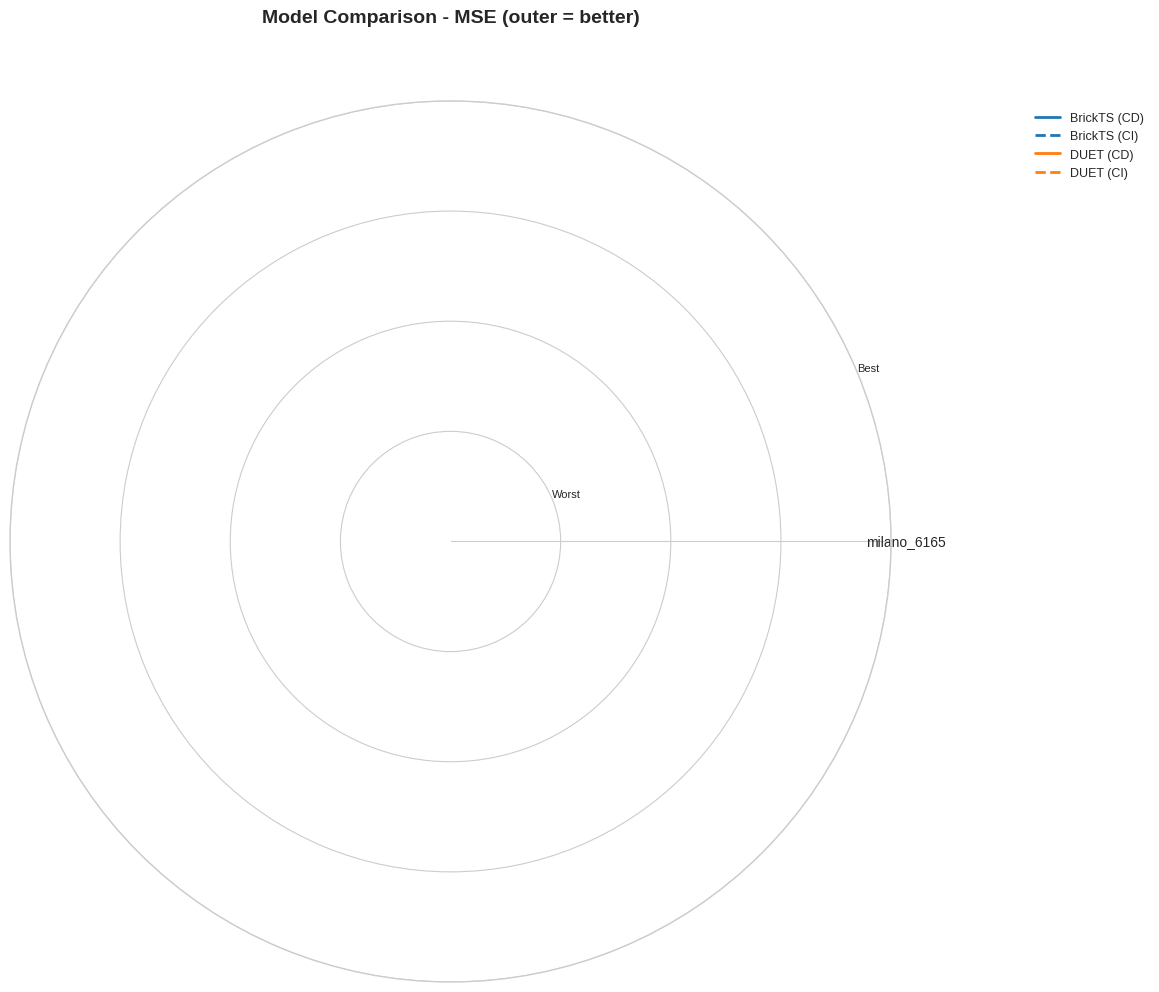

In [11]:
# Cell 7: Create Radar Plot

RADAR_CONFIG = {
    'metric': 'mse',
    'channel': 'OT',
    'models': None,
    'datasets': None,
    'pred_len': None,
    'figsize': (12, 10),
}

fig_radar, ax_radar = create_radar_plot(df_results, **RADAR_CONFIG)
plt.show()

---
## Section 4: Visualization 2 - Pred_Len Trend Line Plot

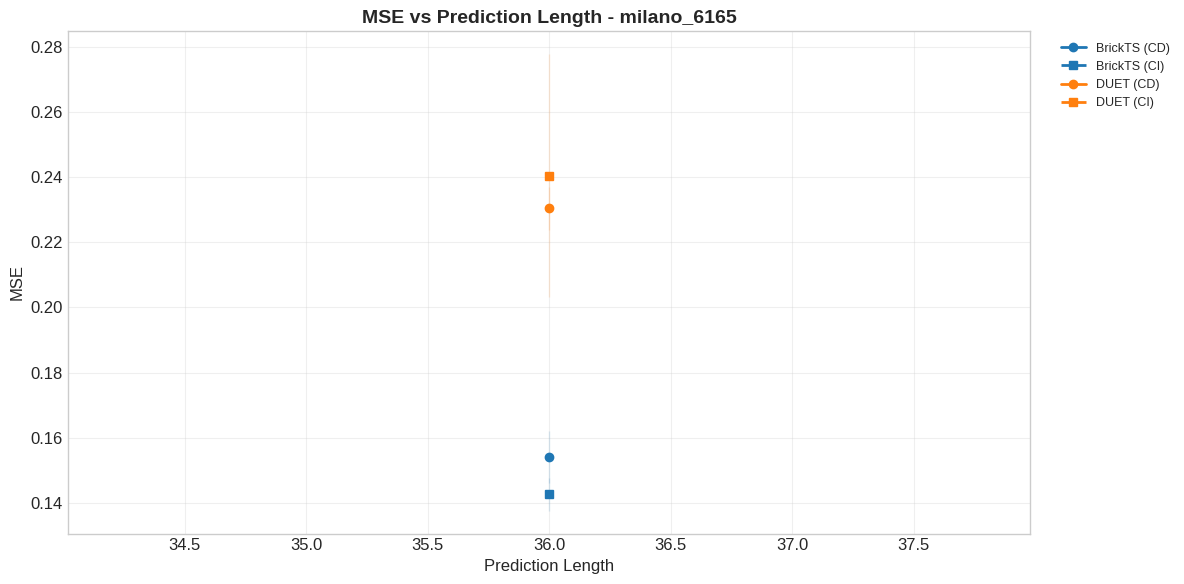

In [12]:
# Cell 8: Line Plot for Pred_Len Trends

def create_pred_len_trend_plot(
    df: pd.DataFrame, metric: str = 'mse', channel: str = 'OT',
    dataset: str = None, models: Optional[List[str]] = None,
    figsize: Tuple[int, int] = (12, 6), title: Optional[str] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    df_filtered = df[df['channel'] == channel].copy()
    if dataset:
        df_filtered = df_filtered[df_filtered['dataset'] == dataset]
    if models is None:
        models = sorted(df_filtered['model'].unique())
    df_filtered = df_filtered[df_filtered['model'].isin(models)]
    
    fig, ax = plt.subplots(figsize=figsize)
    for model in models:
        color = get_model_color(model)
        model_data = df_filtered[df_filtered['model'] == model]
        for mode in ['CD', 'CI']:
            mode_data = model_data[model_data['mode'] == mode].sort_values('pred_len')
            if len(mode_data) == 0:
                continue
            linestyle = MODE_LINESTYLES[mode]
            marker = MODE_MARKERS[mode]
            label = f"{rename_model(model)} ({mode})"
            ax.plot(mode_data['pred_len'], mode_data[metric],
                   linestyle=linestyle, marker=marker, markersize=6,
                   color=color, label=label, linewidth=2)
            std_col = f"{metric}_std"
            if std_col in mode_data.columns and mode_data[std_col].notna().any():
                ax.fill_between(mode_data['pred_len'],
                    mode_data[metric] - mode_data[std_col],
                    mode_data[metric] + mode_data[std_col], alpha=0.15, color=color)
    
    ax.set_xlabel('Prediction Length', fontsize=12)
    ax.set_ylabel(metric.upper(), fontsize=12)
    ds_label = dataset if dataset else 'All Datasets'
    ax.set_title(title or f'{metric.upper()} vs Prediction Length - {ds_label}', fontsize=14, weight='bold')
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig, ax

# Demo
available_datasets = df_results['dataset'].unique()
demo_dataset = available_datasets[0] if len(available_datasets) > 0 else None
fig_trend, ax_trend = create_pred_len_trend_plot(df_results, metric='mse', channel='OT', dataset=demo_dataset)
plt.show()

---
## Section 5: Visualization 3 - Accuracy Difference by Group

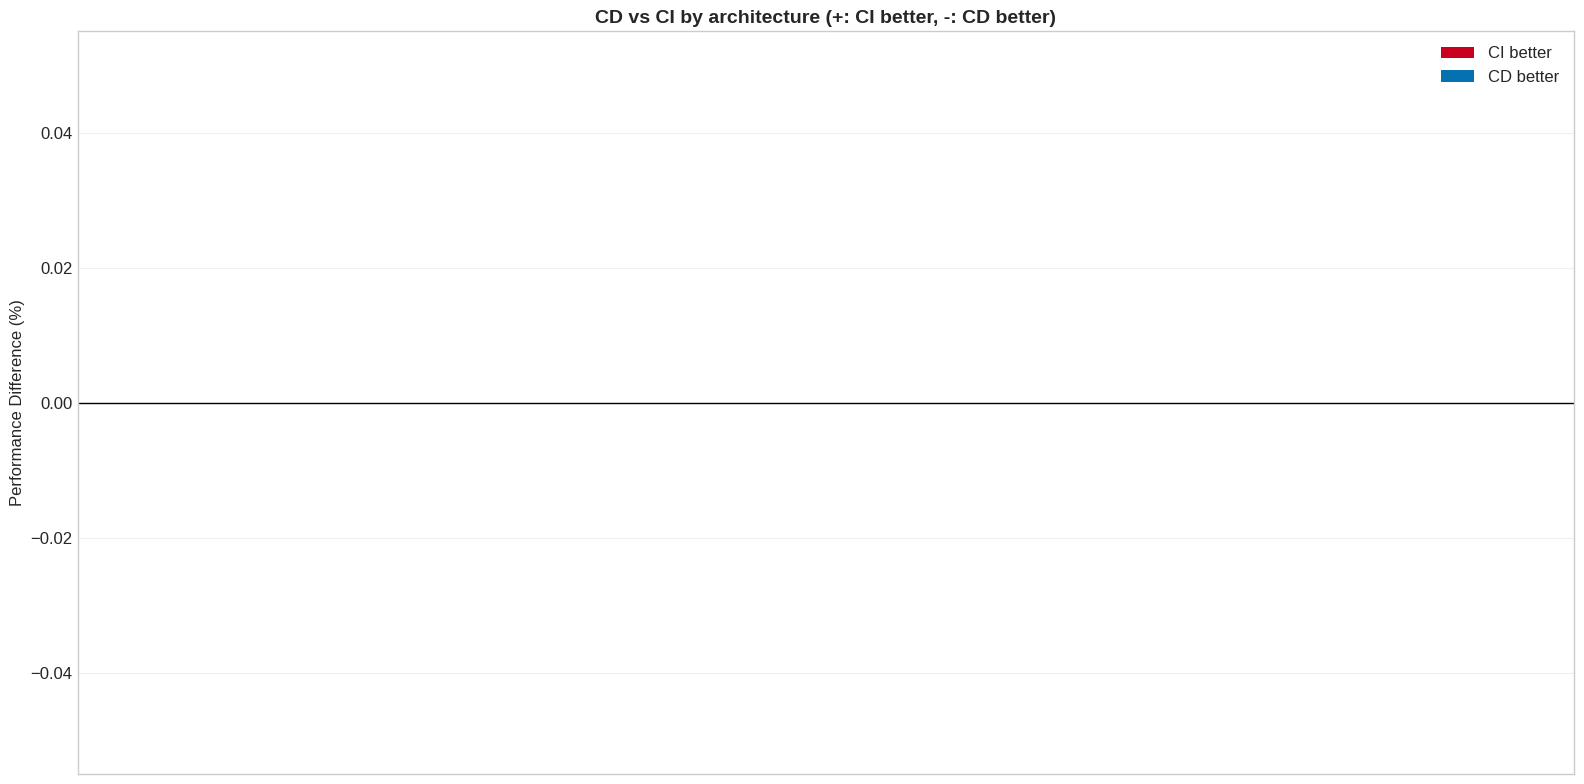

In [13]:
# Cell 9: Model Groups and Accuracy Difference by Group

def get_model_groups():
    return {
        'architecture': {
            'MLP': ['linear', 'dlinear', 'tsmixer', 'timemixer', 'lightts', 'tide'],
            'CNN': ['tcn', 'scinet', 'timesnet', 'micn'],
            'RNN': ['rnn', 'segrnn'],
            'Transformer': ['transformer', 'pyraformer', 'autoformer', 'informer', 'itransformer', 'patchtst']
        },
        'interaction_level': {
            'Direct': ['tcn', 'linear', 'rnn', 'transformer', 'segrnn', 'lightts', 'tide', 'informer'],
            'Spectral': ['timemixer', 'autoformer', 'timesnet'],
            'Decomposition': ['dlinear', 'tsmixer', 'scinet', 'pyraformer', 'micn']
        }
    }

def create_accuracy_difference_by_group(
    df, dataset='all', metric='mse', group_criterion='architecture',
    pred_len=None, channel='OT', figsize=(16, 8)
):
    CD_COLOR, CI_COLOR = '#0571b0', '#ca0020'
    df_f = df[df['channel'] == channel].copy()
    
    if pred_len is None:
        if dataset != 'all':
            pred_len = get_default_pred_len(dataset)
    
    if dataset == 'all':
        rows = [r for _, r in df_f.iterrows() if r['pred_len'] == get_default_pred_len(r['dataset'])]
        df_f = pd.DataFrame(rows)
    else:
        df_f = df_f[df_f['dataset'] == dataset]
        if pred_len:
            df_f = df_f[df_f['pred_len'] == pred_len]
    
    grouped = df_f.groupby(['model', 'mode'])[metric].mean().reset_index()
    cd_data = grouped[grouped['mode'] == 'CD'].set_index('model')[metric]
    ci_data = grouped[grouped['mode'] == 'CI'].set_index('model')[metric]
    common = set(cd_data.index) & set(ci_data.index)
    
    groups = get_model_groups().get(group_criterion, {})
    grouped_models = {g: [m for m in ms if m in common] for g, ms in groups.items()}
    grouped_models = {k: v for k, v in grouped_models.items() if v}
    
    improvements = {}
    for m in common:
        cd, ci = cd_data[m], ci_data[m]
        improvements[m] = (cd - ci) / cd * 100 if ci < cd else -(ci - cd) / ci * 100
    
    fig, ax = plt.subplots(figsize=figsize)
    x_pos, labels, colors, vals = [], [], [], []
    pos = 0
    for gname, mlist in grouped_models.items():
        for m in mlist:
            x_pos.append(pos)
            labels.append(rename_model(m))
            imp = improvements[m]
            vals.append(imp)
            colors.append(CI_COLOR if imp > 0 else CD_COLOR)
            pos += 1
        pos += 1
    
    ax.bar(x_pos, vals, color=colors, edgecolor='black', linewidth=0.5)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Performance Difference (%)')
    ax.set_title(f'CD vs CI by {group_criterion} (+: CI better, -: CD better)', weight='bold')
    ax.legend(handles=[Patch(facecolor=CI_COLOR, label='CI better'), Patch(facecolor=CD_COLOR, label='CD better')])
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    return fig, ax

fig_diff, ax_diff = create_accuracy_difference_by_group(df_results, dataset='all', metric='mse')
plt.show()

---
## Section 6: Visualization 4 - CD Wins by Dataset

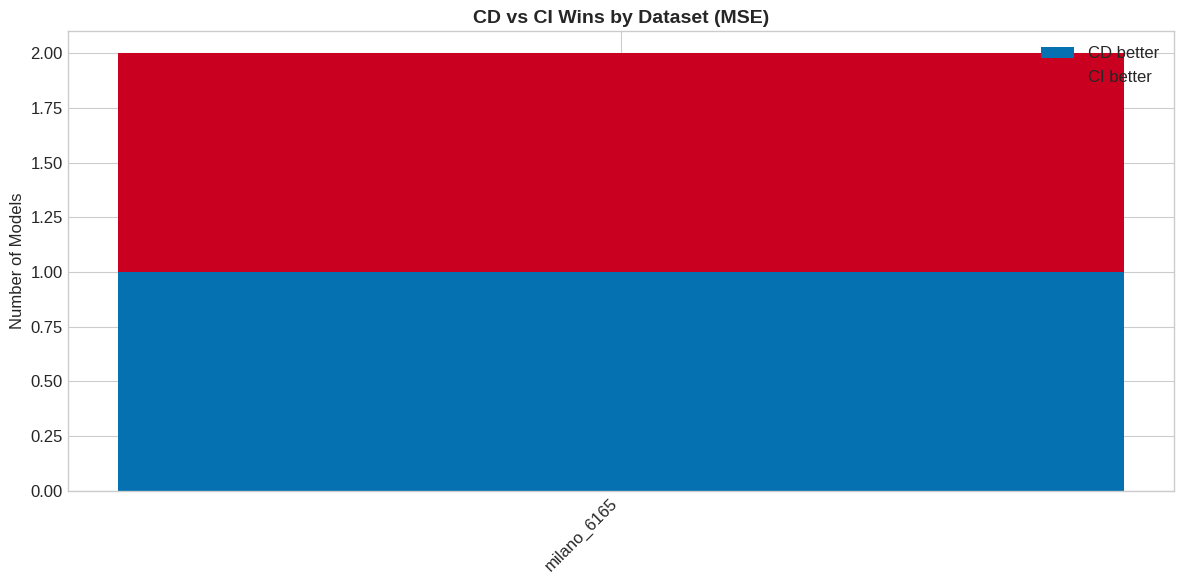

In [14]:
# Cell 10: CD Wins by Dataset

def plot_cd_wins_by_dataset(df, metric='mse', channel='OT', pred_len=None, 
                            custom_order=None, figsize=(12, 6)):
    CD_COLOR, CI_COLOR = '#0571b0', '#ca0020'
    df_f = df[df['channel'] == channel].copy()
    
    if pred_len is None:
        rows = [r for _, r in df_f.iterrows() if r['pred_len'] == get_default_pred_len(r['dataset'])]
        df_f = pd.DataFrame(rows)
    else:
        df_f = df_f[df_f['pred_len'] == pred_len]
    
    grouped = df_f.groupby(['dataset', 'model', 'mode'])[metric].mean().reset_index()
    pivot = grouped.pivot_table(index=['dataset', 'model'], columns='mode', values=metric)
    pivot = pivot.dropna(subset=['CD', 'CI']).reset_index()
    
    wins, totals = {}, {}
    for ds, sub in pivot.groupby('dataset'):
        wins[ds] = int((sub['CD'] < sub['CI']).sum())
        totals[ds] = len(sub)
    
    items = custom_order if custom_order else sorted(wins.keys(), key=lambda k: wins[k], reverse=True)
    items = [i for i in items if i in wins]
    
    x = np.arange(len(items))
    cd_counts = np.array([wins[k] for k in items])
    ci_counts = np.array([totals[k] for k in items]) - cd_counts
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x, cd_counts, color=CD_COLOR, label='CD better')
    ax.bar(x, ci_counts, bottom=cd_counts, color=CI_COLOR, label='CI better')
    ax.set_xticks(x)
    ax.set_xticklabels(items, rotation=45, ha='right')
    ax.set_ylabel('Number of Models')
    ax.set_title(f'CD vs CI Wins by Dataset ({metric.upper()})', weight='bold')
    ax.legend()
    plt.tight_layout()
    return fig, ax

fig_wins, ax_wins = plot_cd_wins_by_dataset(df_results, metric='mse')
plt.show()

---
## Section 7: Visualization 5 - Performance Heatmap

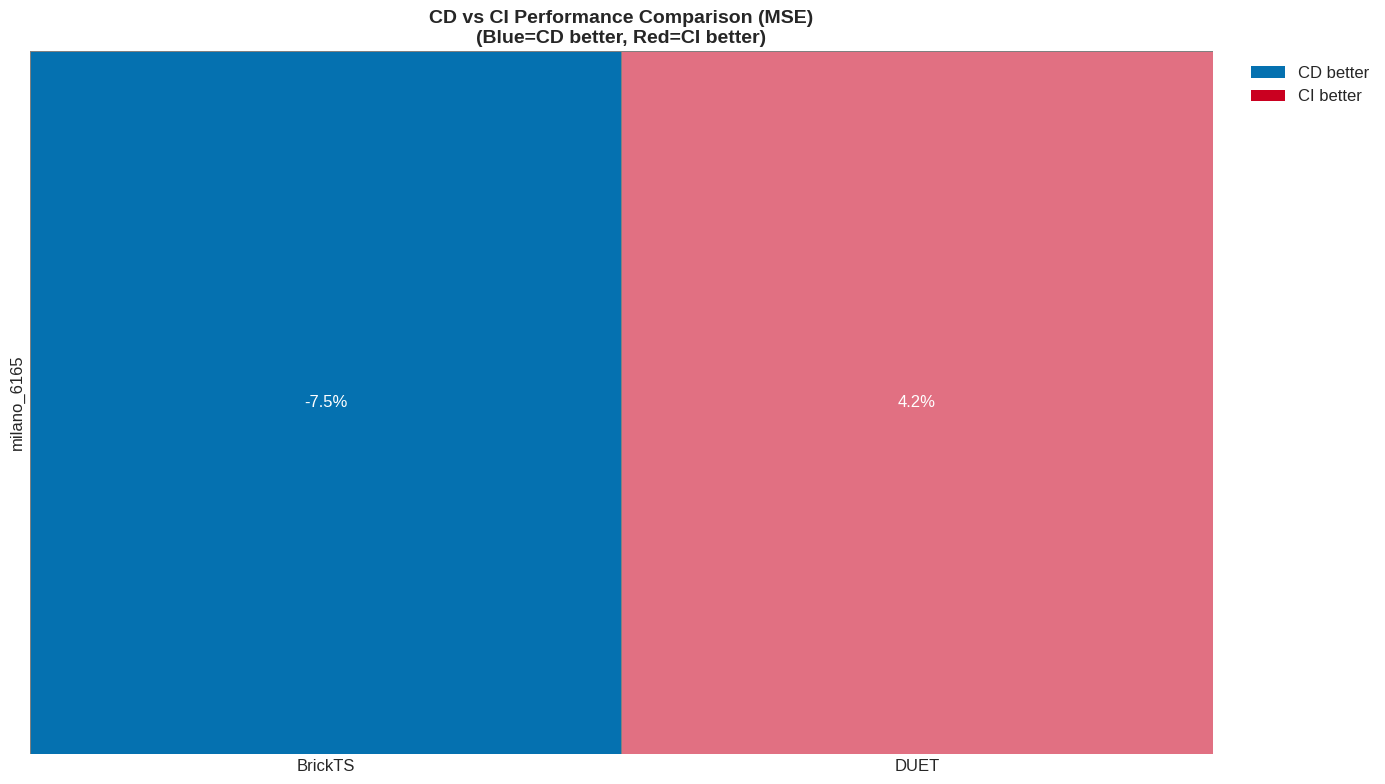

In [15]:
# Cell 11: Performance Heatmap

def create_performance_heatmap(df, metric='mse', channel='OT', pred_len=None,
                               model_order=None, dataset_order=None, figsize=(14, 8)):
    CD_COLOR, CI_COLOR = '#0571b0', '#ca0020'
    df_f = df[df['channel'] == channel].copy()
    
    if pred_len is None:
        rows = [r for _, r in df_f.iterrows() if r['pred_len'] == get_default_pred_len(r['dataset'])]
        df_f = pd.DataFrame(rows)
    else:
        df_f = df_f[df_f['pred_len'] == pred_len]
    
    grouped = df_f.groupby(['dataset', 'model', 'mode'])[metric].mean().reset_index()
    cd = grouped[grouped['mode'] == 'CD'].set_index(['dataset', 'model'])[metric]
    ci = grouped[grouped['mode'] == 'CI'].set_index(['dataset', 'model'])[metric]
    common = cd.index.intersection(ci.index)
    
    heat_vals, annot_vals = {}, {}
    for idx in common:
        cd_v, ci_v = float(cd[idx]), float(ci[idx])
        if cd_v == 0 and ci_v == 0:
            heat_vals[idx], annot_vals[idx] = 0, 0
        else:
            diff = (ci_v - cd_v) / max(abs(cd_v), abs(ci_v)) * 100
            heat_vals[idx] = diff
            annot_vals[idx] = diff
    
    heat_df = pd.Series(heat_vals).unstack(fill_value=np.nan)
    annot_df = pd.Series(annot_vals).unstack(fill_value=np.nan)
    
    if model_order:
        cols = [m for m in model_order if m in heat_df.columns]
        heat_df, annot_df = heat_df[cols], annot_df[cols]
    if dataset_order:
        rows = [d for d in dataset_order if d in heat_df.index]
        heat_df, annot_df = heat_df.loc[rows], annot_df.loc[rows]
    
    cmap = LinearSegmentedColormap.from_list('cd_ci', [CD_COLOR, '#ffffff', CI_COLOR], N=256)
    vmax = max(abs(heat_df.min().min()), abs(heat_df.max().max()), 1)
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    
    fig, ax = plt.subplots(figsize=figsize)
    annot_str = annot_df.applymap(lambda x: f'{x:.1f}%' if pd.notna(x) else '')
    sns.heatmap(heat_df, cmap=cmap, norm=norm, annot=annot_str, fmt='', cbar=False,
                linewidths=0.5, linecolor='gray', ax=ax)
    
    ax.set_title(f'CD vs CI Performance Comparison ({metric.upper()})\n(Blue=CD better, Red=CI better)', weight='bold')
    ax.legend(handles=[Patch(facecolor=CD_COLOR, label='CD better'), Patch(facecolor=CI_COLOR, label='CI better')],
              loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    return fig, ax

fig_heat, ax_heat = create_performance_heatmap(df_results, metric='mse')
plt.show()

---
## Section 8: Visualization 6 - Efficiency Comparison Heatmap

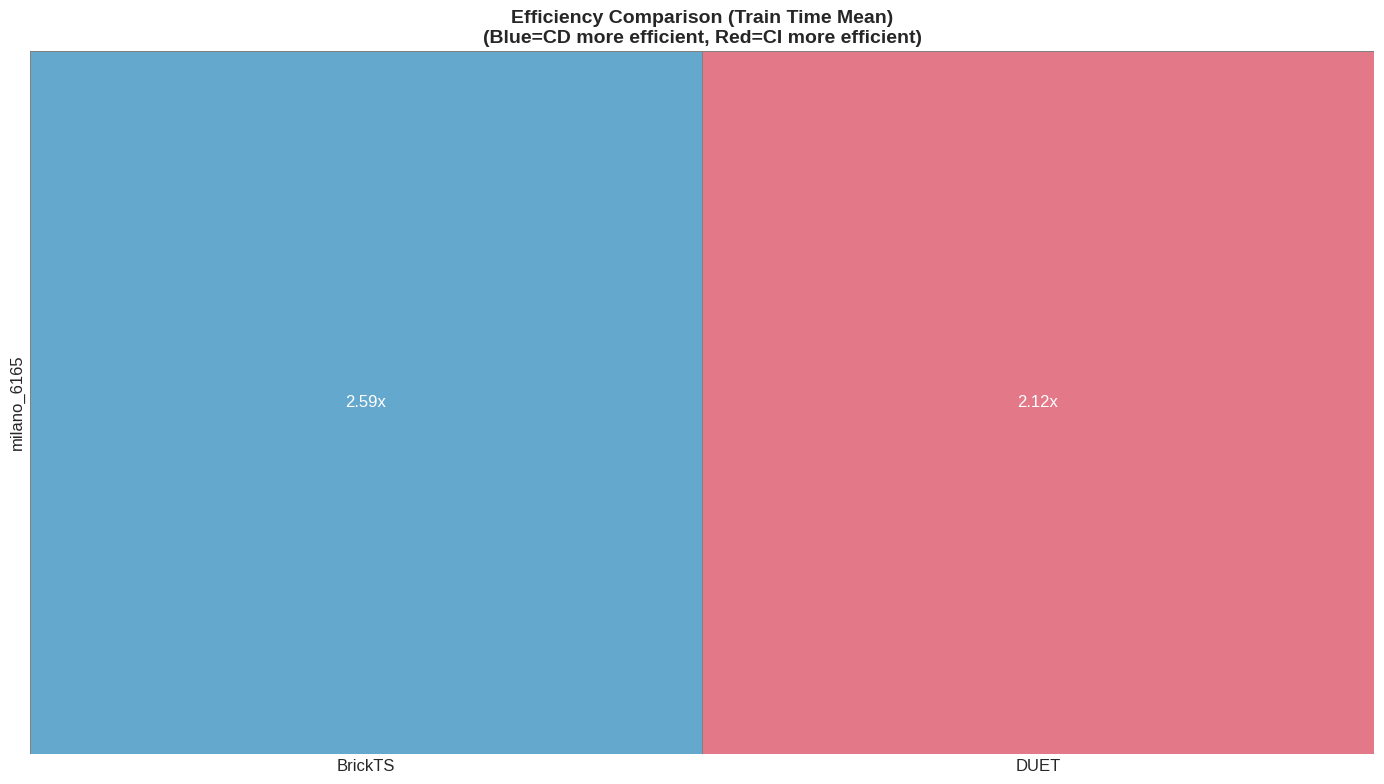

In [16]:
# Cell 12: Efficiency Comparison Heatmap

def create_efficiency_comparison_heatmap(df, column='train_time_mean', channel='OT',
                                        model_order=None, dataset_order=None, figsize=(14, 8)):
    CD_COLOR, CI_COLOR = '#0571b0', '#ca0020'
    df_f = df[df['channel'] == channel].copy()
    
    rows = [r for _, r in df_f.iterrows() if r['pred_len'] == get_default_pred_len(r['dataset'])]
    df_f = pd.DataFrame(rows)
    
    grouped = df_f.groupby(['dataset', 'model', 'mode'])[column].mean().reset_index()
    cd = grouped[grouped['mode'] == 'CD'].set_index(['dataset', 'model'])[column]
    ci = grouped[grouped['mode'] == 'CI'].set_index(['dataset', 'model'])[column]
    common = cd.index.intersection(ci.index)
    
    heat_vals, annot_vals = {}, {}
    for idx in common:
        cd_v, ci_v = float(cd[idx]), float(ci[idx])
        if not np.isfinite(cd_v) or not np.isfinite(ci_v):
            continue
        small, big = min(cd_v, ci_v), max(cd_v, ci_v)
        ratio = small / big if big > 0 else 1
        sign = -1 if cd_v < ci_v else (1 if ci_v < cd_v else 0)
        heat_vals[idx] = (1 - ratio) * sign
        annot_vals[idx] = big / small if small > 0 else float('inf')
    
    heat_df = pd.Series(heat_vals).unstack(fill_value=np.nan)
    annot_df = pd.Series(annot_vals).unstack(fill_value=np.nan)
    
    if model_order:
        cols = [m for m in model_order if m in heat_df.columns]
        heat_df, annot_df = heat_df[cols], annot_df[cols]
    
    cmap = LinearSegmentedColormap.from_list('eff', [CD_COLOR, '#ffffff', CI_COLOR], N=256)
    norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    
    fig, ax = plt.subplots(figsize=figsize)
    annot_str = annot_df.applymap(lambda x: f'{x:.2f}x' if pd.notna(x) and np.isfinite(x) else '')
    sns.heatmap(heat_df, cmap=cmap, norm=norm, annot=annot_str, fmt='', cbar=False,
                linewidths=0.5, linecolor='gray', ax=ax)
    
    col_title = column.replace('_', ' ').title()
    ax.set_title(f'Efficiency Comparison ({col_title})\n(Blue=CD more efficient, Red=CI more efficient)', weight='bold')
    plt.tight_layout()
    return fig, ax

fig_eff, ax_eff = create_efficiency_comparison_heatmap(df_results, column='train_time_mean')
plt.show()

---
## Section 9: Visualization 7 - Efficiency Wins by Model

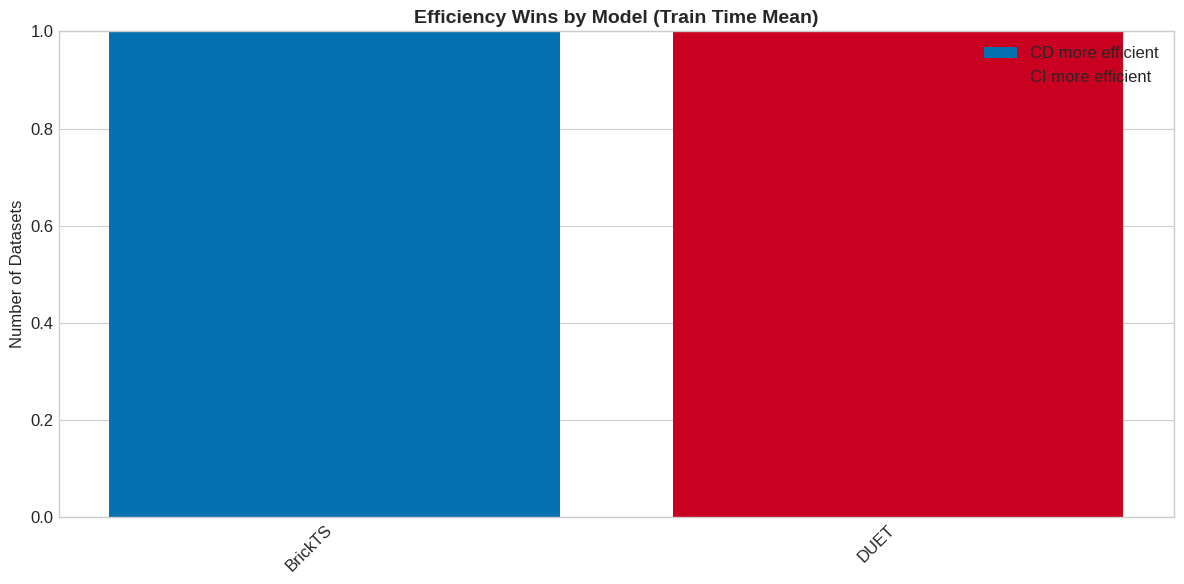

In [17]:
# Cell 13: Efficiency Wins by Model

def plot_efficiency_wins_by_model(df, column='train_time_mean', channel='OT',
                                  custom_model_order=None, figsize=(12, 6)):
    CD_COLOR, CI_COLOR = '#0571b0', '#ca0020'
    df_f = df[df['channel'] == channel].copy()
    
    rows = [r for _, r in df_f.iterrows() if r['pred_len'] == get_default_pred_len(r['dataset'])]
    df_f = pd.DataFrame(rows)
    
    grouped = df_f.groupby(['dataset', 'model', 'mode'])[column].mean().reset_index()
    pivot = grouped.pivot_table(index=['dataset', 'model'], columns='mode', values=column)
    pivot = pivot.dropna(subset=['CD', 'CI']).reset_index()
    
    wins, totals = {}, {}
    for mdl, sub in pivot.groupby('model'):
        wins[mdl] = int((sub['CD'] < sub['CI']).sum())
        totals[mdl] = len(sub)
    
    items = custom_model_order if custom_model_order else sorted(wins.keys(), key=lambda k: wins[k], reverse=True)
    items = [i for i in items if i in wins]
    
    x = np.arange(len(items))
    cd_counts = np.array([wins[k] for k in items])
    ci_counts = np.array([totals[k] for k in items]) - cd_counts
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x, cd_counts, color=CD_COLOR, label='CD more efficient')
    ax.bar(x, ci_counts, bottom=cd_counts, color=CI_COLOR, label='CI more efficient')
    ax.set_xticks(x)
    ax.set_xticklabels([rename_model(m) for m in items], rotation=45, ha='right')
    ax.set_ylabel('Number of Datasets')
    col_title = column.replace('_', ' ').title()
    ax.set_title(f'Efficiency Wins by Model ({col_title})', weight='bold')
    ax.legend()
    plt.tight_layout()
    return fig, ax

fig_eff_wins, ax_eff_wins = plot_efficiency_wins_by_model(df_results, column='train_time_mean')
plt.show()

---
## Section 10: Visualization 8 - Two-Axis Comparison

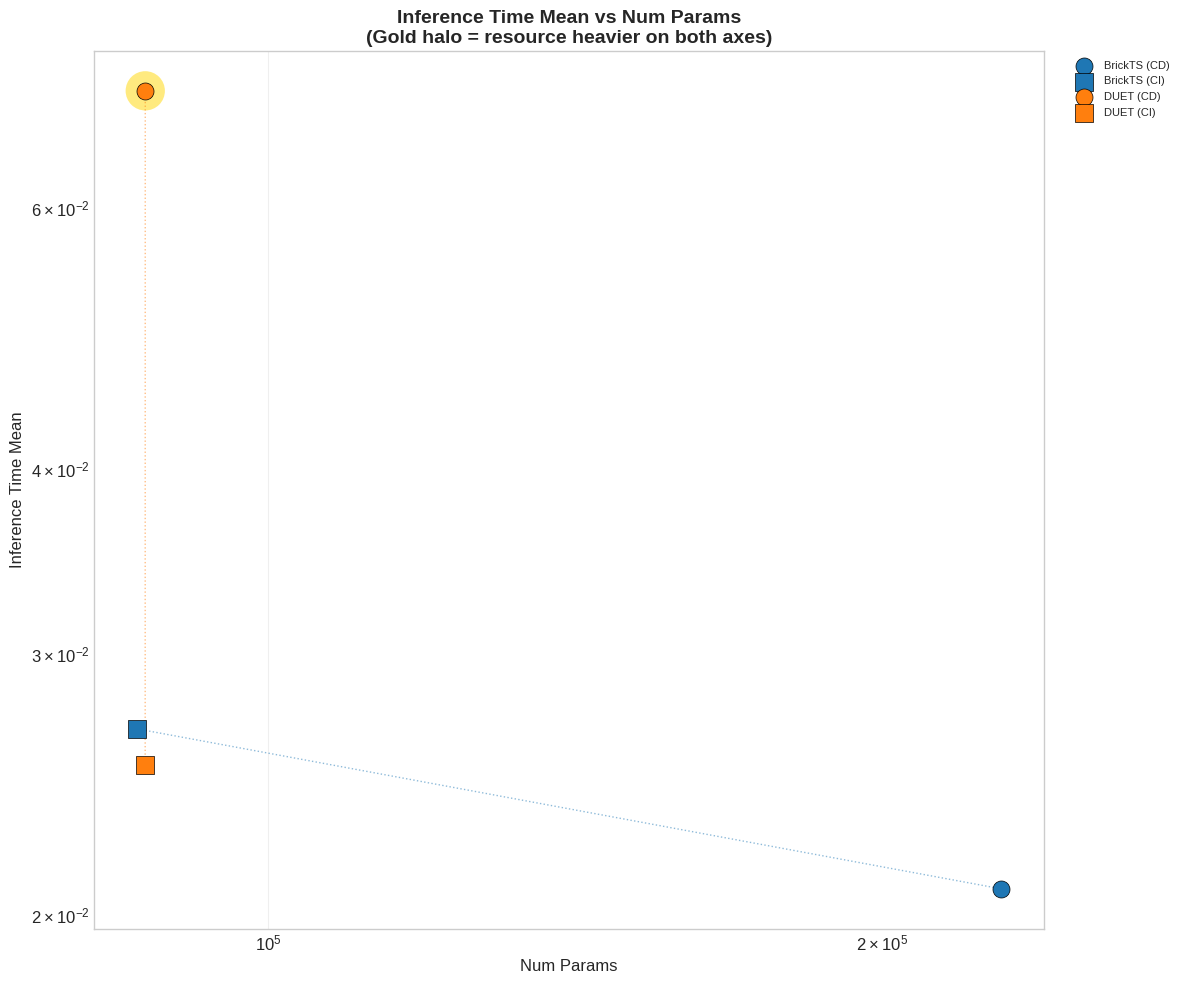

In [18]:
# Cell 14: Two-Axis Comparison (Accuracy vs Efficiency)

def create_two_axis_comparison(df, x_metric='num_params', y_metric='inference_time_mean',
                               channel='OT', dataset_filter='all', strategy_filter='both',
                               use_log_scale=True, show_connections=True, 
                               show_resource_heavy=True, figsize=(12, 10)):
    """
    Two-axis comparison plot.
    - show_resource_heavy: Mark with gold halo when BOTH axes have higher values (resource-heavier)
    """
    df_f = df[df['channel'] == channel].copy()
    
    rows = [r for _, r in df_f.iterrows() if r['pred_len'] == get_default_pred_len(r['dataset'])]
    df_f = pd.DataFrame(rows)
    
    if dataset_filter != 'all':
        df_f = df_f[df_f['dataset'] == dataset_filter]
    
    if strategy_filter != 'both':
        df_f = df_f[df_f['mode'] == strategy_filter]
    
    avg = df_f.groupby(['model', 'mode']).agg({x_metric: 'mean', y_metric: 'mean'}).reset_index()
    
    # Determine resource-heavy points (BOTH x and y are max for that model)
    avg['resource_heavy'] = False
    if show_resource_heavy and strategy_filter == 'both':
        for model in avg['model'].unique():
            sub = avg[avg['model'] == model]
            if len(sub) < 2:
                continue
            max_x = sub[x_metric].max()
            max_y = sub[y_metric].max()
            # Only mark as heavy if BOTH axes have max value (same row)
            both_max_mask = (avg['model'] == model) & (avg[x_metric] == max_x) & (avg[y_metric] == max_y)
            avg.loc[both_max_mask, 'resource_heavy'] = True
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # (A) First, draw gold halo for resource-heavy points (behind main markers)
    if show_resource_heavy:
        heavy_rows = avg[avg['resource_heavy']]
        for _, row in heavy_rows.iterrows():
            ax.scatter(row[x_metric], row[y_metric], s=800, alpha=0.5, 
                      c='gold', marker='o', edgecolors='none', zorder=1)
    
    # (B) Draw main markers and collect legend handles
    legend_handles = []
    models = avg['model'].unique()
    for model in models:
        color = get_model_color(model)
        model_data = avg[avg['model'] == model]
        
        for mode in ['CD', 'CI']:
            m_data = model_data[model_data['mode'] == mode]
            if len(m_data) == 0:
                continue
            marker = MODE_MARKERS[mode]
            
            scatter = ax.scatter(m_data[x_metric], m_data[y_metric], c=color, marker=marker, 
                                s=150, edgecolors='black', linewidths=0.5, zorder=2)
            legend_handles.append((scatter, f'{rename_model(model)} ({mode})'))
        
        # Draw connection line between CD and CI
        if show_connections and strategy_filter == 'both':
            cd_d = model_data[model_data['mode'] == 'CD']
            ci_d = model_data[model_data['mode'] == 'CI']
            if len(cd_d) > 0 and len(ci_d) > 0:
                ax.plot([cd_d[x_metric].values[0], ci_d[x_metric].values[0]],
                       [cd_d[y_metric].values[0], ci_d[y_metric].values[0]],
                       color=color, linestyle=':', alpha=0.5, linewidth=1, zorder=1)
    
    if use_log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    ax.set_xlabel(x_metric.replace('_', ' ').title(), fontsize=12)
    ax.set_ylabel(y_metric.replace('_', ' ').title(), fontsize=12)
    ax.set_title(f'{y_metric.replace("_", " ").title()} vs {x_metric.replace("_", " ").title()}\n(Gold halo = resource heavier on both axes)', fontsize=14, weight='bold')
    
    # Create legend without resource-heavy halo
    ax.legend([h[0] for h in legend_handles], [h[1] for h in legend_handles],
              loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=8)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig, ax

fig_2ax, ax_2ax = create_two_axis_comparison(df_results, x_metric='num_params', y_metric='inference_time_mean')
plt.show()

---
## Section 11: Visualization 9 - Prediction vs Ground Truth

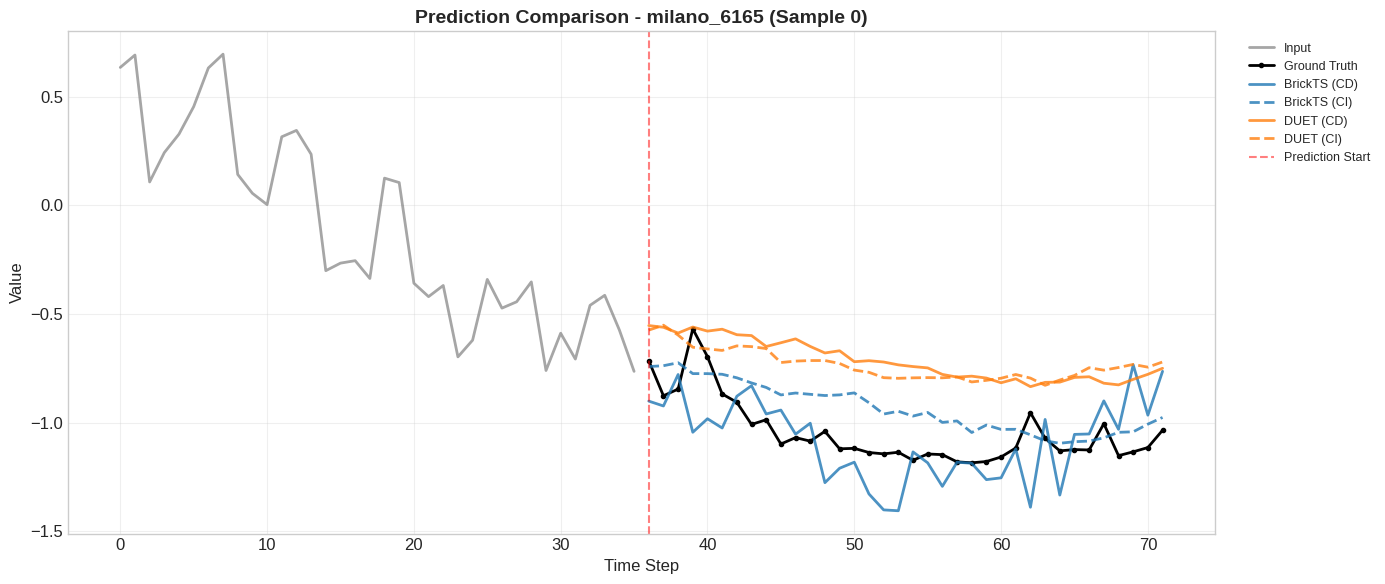

Prediction comparison function defined. Adjust parameters to visualize.


In [19]:
# Cell 15: Prediction vs Ground Truth Visualization

def plot_prediction_comparison(
    results_dir: Path, dataset: str, seq_len: int, pred_len: int,
    models: List[str], modes: List[str] = ['CD', 'CI'],
    sample_idx: int = 0, channel_idx: int = -1, repeat: int = 0,
    channel: str = 'OT', figsize: Tuple[int, int] = (14, 6)
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Compare predictions from multiple models against ground truth.
    X-axis: time steps [input : prediction]
    Y-axis: feature values
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    input_plotted = False
    true_plotted = False
    
    for model in models:
        color = get_model_color(model)
        
        for mode in modes:
            data = load_npy_predictions(results_dir, dataset, seq_len, pred_len,
                                       model, mode, repeat, channel)
            
            if 'pred' not in data or 'true' not in data:
                continue
            
            pred = data['pred']
            true = data['true']
            
            # Handle different array shapes
            if len(pred.shape) == 3:
                pred_sample = pred[sample_idx, :, channel_idx]
                true_sample = true[sample_idx, :, channel_idx]
            else:
                pred_sample = pred[sample_idx] if len(pred.shape) > 1 else pred
                true_sample = true[sample_idx] if len(true.shape) > 1 else true
            
            pred_len_actual = len(pred_sample)
            pred_x = np.arange(seq_len, seq_len + pred_len_actual)
            
            # Plot input (only once)
            if 'input' in data and not input_plotted:
                inp = data['input']
                if len(inp.shape) == 3:
                    inp_sample = inp[sample_idx, :, channel_idx]
                else:
                    inp_sample = inp[sample_idx] if len(inp.shape) > 1 else inp
                inp_x = np.arange(len(inp_sample))
                ax.plot(inp_x, inp_sample, color='gray', linewidth=2, label='Input', alpha=0.7)
                input_plotted = True
            
            # Plot ground truth (only once)
            if not true_plotted:
                ax.plot(pred_x, true_sample, color='black', linewidth=2, 
                       label='Ground Truth', linestyle='-', marker='.')
                true_plotted = True
            
            # Plot prediction
            linestyle = MODE_LINESTYLES[mode]
            label = f'{rename_model(model)} ({mode})'
            ax.plot(pred_x, pred_sample, color=color, linewidth=2,
                   linestyle=linestyle, label=label, alpha=0.8)
    
    ax.axvline(x=seq_len, color='red', linestyle='--', alpha=0.5, label='Prediction Start')
    ax.set_xlabel('Time Step', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_title(f'Prediction Comparison - {dataset} (Sample {sample_idx})', fontsize=14, weight='bold')
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig, ax

# Demo (uncomment and adjust parameters to use)
fig_pred, ax_pred = plot_prediction_comparison(
    RESULTS_DIR, dataset='milano_6165', seq_len=36, pred_len=36,
    models=['BrickTS', 'DUET'], modes=['CD', 'CI'], sample_idx=0
)
plt.show()
print("Prediction comparison function defined. Adjust parameters to visualize.")

---
## Section 12: Visualization 10 - Critical Difference Diagram

Critical Difference function defined. Install aeon package and uncomment to use.


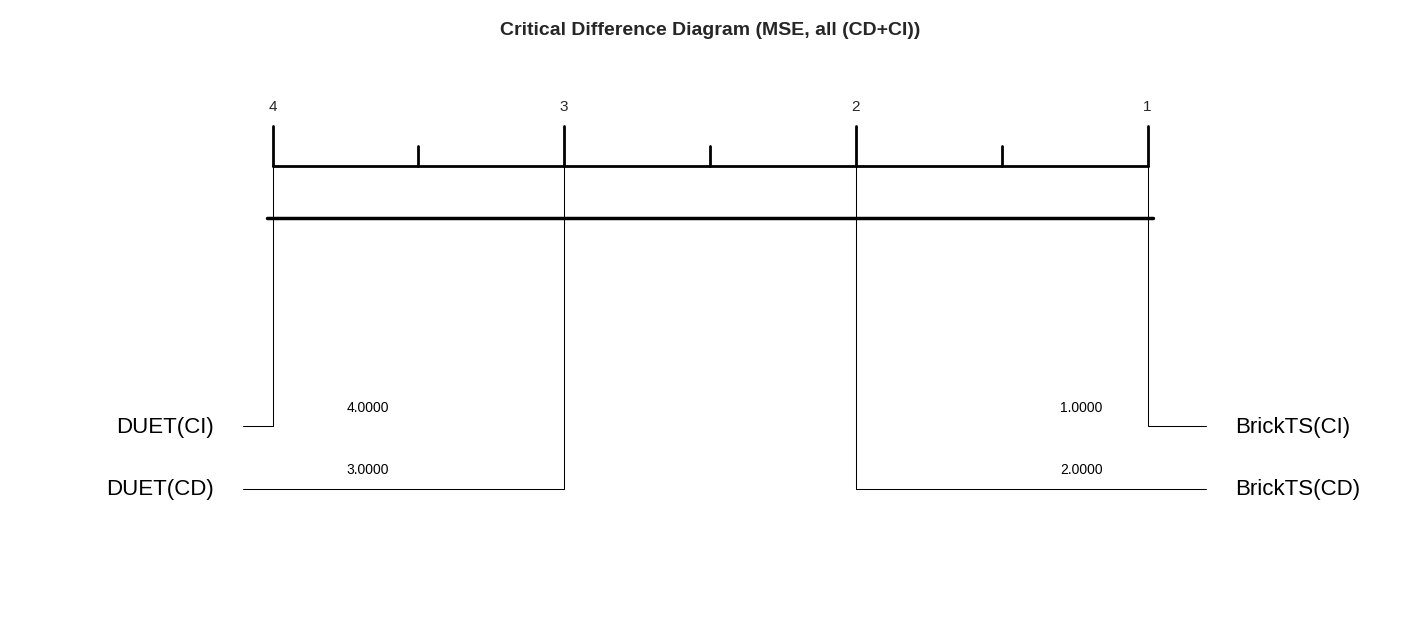

In [20]:
# Cell 16: Critical Difference Diagram
# Requires: pip install aeon

def create_critical_difference_plot(df, metric='mse', channel='OT', mode='all',
                                   alpha=0.1, figsize=(14, 6)):
    """
    Create Critical Difference diagram using Wilcoxon-Holm test.
    
    Args:
        mode: Comparison mode
            - 'all': Compare all (CD and CI treated as separate models, e.g., Linear(CD) vs Linear(CI) vs DLinear(CD)...)
            - 'CD': Compare CD models only (Linear vs DLinear vs ...)
            - 'CI': Compare CI models only (Linear vs DLinear vs ...)
            - 'both': Same as 'all' (alias for backward compatibility)
    """
    from aeon.visualisation import plot_critical_difference
    
    df_f = df[df['channel'] == channel].copy()
    rows = [r for _, r in df_f.iterrows() if r['pred_len'] == get_default_pred_len(r['dataset'])]
    df_f = pd.DataFrame(rows)
    df_f = df_f.drop_duplicates(subset=['dataset', 'model', 'mode'])
    
    # Handle mode aliases
    if mode in ['all', 'both']:
        # Compare all: CD and CI as separate entries
        df_f['label'] = df_f.apply(lambda r: f"{rename_model(r['model'])}({r['mode']})", axis=1)
        pivot = df_f.pivot(index='dataset', columns='label', values=metric)
        mode_label = 'all (CD+CI)'
    elif mode == 'CD':
        # Compare CD models only
        df_f = df_f[df_f['mode'] == 'CD']
        df_f['label'] = df_f['model'].apply(rename_model)
        pivot = df_f.pivot(index='dataset', columns='label', values=metric)
        mode_label = 'CD only'
    elif mode == 'CI':
        # Compare CI models only
        df_f = df_f[df_f['mode'] == 'CI']
        df_f['label'] = df_f['model'].apply(rename_model)
        pivot = df_f.pivot(index='dataset', columns='label', values=metric)
        mode_label = 'CI only'
    else:
        raise ValueError(f"Invalid mode: {mode}. Use 'all', 'both', 'CD', or 'CI'")
    
    pivot = pivot.dropna(axis=1, how='all').dropna(axis=0, how='any')
    
    scores = pivot.to_numpy(dtype=float)
    labels = pivot.columns.tolist()
    
    fig, ax = plot_critical_difference(
        scores=scores, labels=labels, lower_better=True,
        test='wilcoxon', correction='holm', alpha=alpha, reverse=True
    )
    fig.set_size_inches(figsize)
    fig.suptitle(f'Critical Difference Diagram ({metric.upper()}, {mode_label})', fontsize=14, weight='bold')
    plt.tight_layout()
    return fig, ax

# Demo (requires aeon package)
# Compare all CD and CI models together (default)
fig_cd_all, ax_cd_all = create_critical_difference_plot(df_results, metric='mse', mode='all')

# Compare CD models only
# fig_cd_only, ax_cd_only = create_critical_difference_plot(df_results, metric='mse', mode='CD')

# Compare CI models only
# fig_ci_only, ax_ci_only = create_critical_difference_plot(df_results, metric='mse', mode='CI')

# plt.show()
print("Critical Difference function defined. Install aeon package and uncomment to use.")